<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/07_Time_Series_Classification_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/timeseriesAI/tsai/tree/main/tutorial_nbs

# Import libraries 📚

In [1]:
import h5py
import sklearn

In [2]:
from tsai.all import *
computer_setup()

os              : Linux-3.10.0-1160.11.1.el7.x86_64-x86_64-with-glibc2.17
python          : 3.8.13
tsai            : 0.3.2
fastai          : 2.6.3
fastcore        : 1.4.3
torch           : 1.11.0
device          : 1 gpu (['NVIDIA A100-SXM4-40GB'])
cpu cores       : 48
threads per cpu : 2
RAM             : 1007.53 GB
GPU memory      : [39.59] GB


# Load data 🔢

In [10]:
#f2 = h5py.File('/home/h1/saar378b/Data/DWTunnormalizecoif1binomial.hdf5', 'r')
#e1 =  f2['Rawnur150']
#xw = e1[:] 
#e10 = f2['target']
#target = e10[:]


In [11]:
#target = target.astype('<U3')
#np.save('./data/Rawnur150',xw)
#np.save('./data/target',target)


In [12]:
xw     = np.load('./data/Rawnur150.npy',mmap_mode='c')
target = np.load('./data/target.npy',mmap_mode='c')


In [13]:
print(xw.shape,target.shape)

(65346, 11, 450) (65346,)


In [14]:
target

memmap(['0', '0', '0', ..., '0', '0', '1'], dtype='<U1')

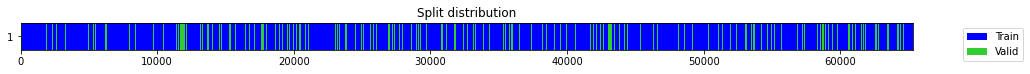

In [15]:
splits = get_splits(target, valid_size=.2, stratify=True, random_state=23, shuffle=True)


In [16]:
#dsid = 'NATOPS'
#X, y, splits = get_UCR_data(dsid, split_data=False)
#y

# InceptionTime ⎘

For comparison I will include a state-of-the-art time series model as Inception Time. 

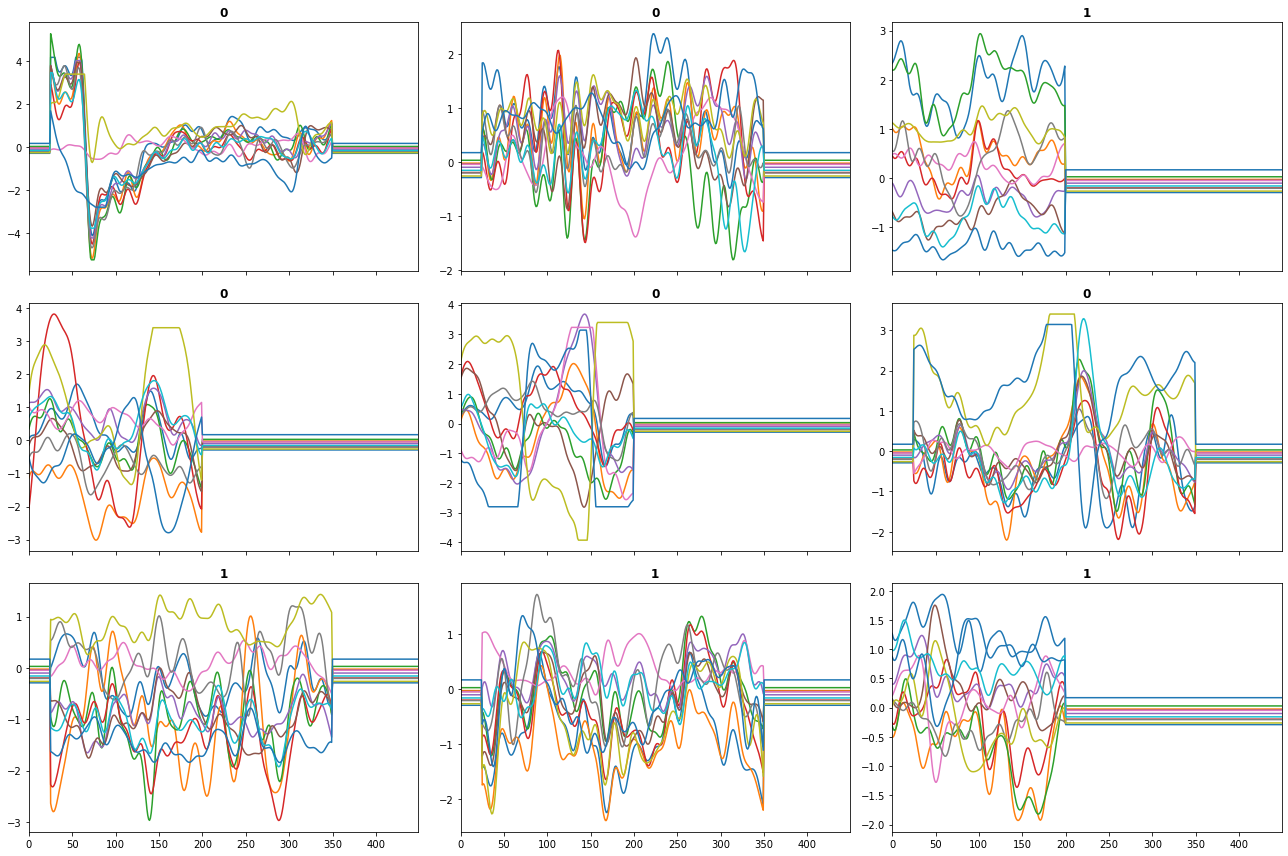

In [17]:
bs = 64
tfms  = [None, [Categorize()]]
dsets = TSDatasets(xw, target, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=TSStandardize(by_var=True))
dls.show_batch()

In [ ]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=[RocAucBinary(), accuracy], cbs=ShowGraphCallback2())
learn.lr_find()

In [ ]:
start = time.time()
learn.fit_one_cycle(10, lr_max=0.0003)
print('\nElapsed time:', time.time() - start)

We can see that even if valid loss goes up, the model doesn't overfit as there's no drop in performance.

In [ ]:
PATHone = Path('./models/Inception2classes.pkl')
PATHone.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATHone)

In [ ]:
learn_cpu = load_learner(PATHone,cpu=True)


In [ ]:
learn.show_results(sharey=True)

In [ ]:
learn.show_probas()

In [ ]:
#interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True,figsize=(10,10))

In [ ]:
learn.feature_importance(key_metric_idx=1)

In [ ]:
test_probas, test_targets, test_preds = learn.get_X_preds(X_test,with_decoded=True)


In [ ]:
sklearn.metrics.accuracy_score(y_test, p)

# TST baseline 🧢

In [18]:
splits

((#52277) [34912,56120,55590,57157,21944,30994,31858,10787,59841,62808...],
 (#13069) [22014,19194,6459,37483,47730,24087,40648,45066,57628,37650...])

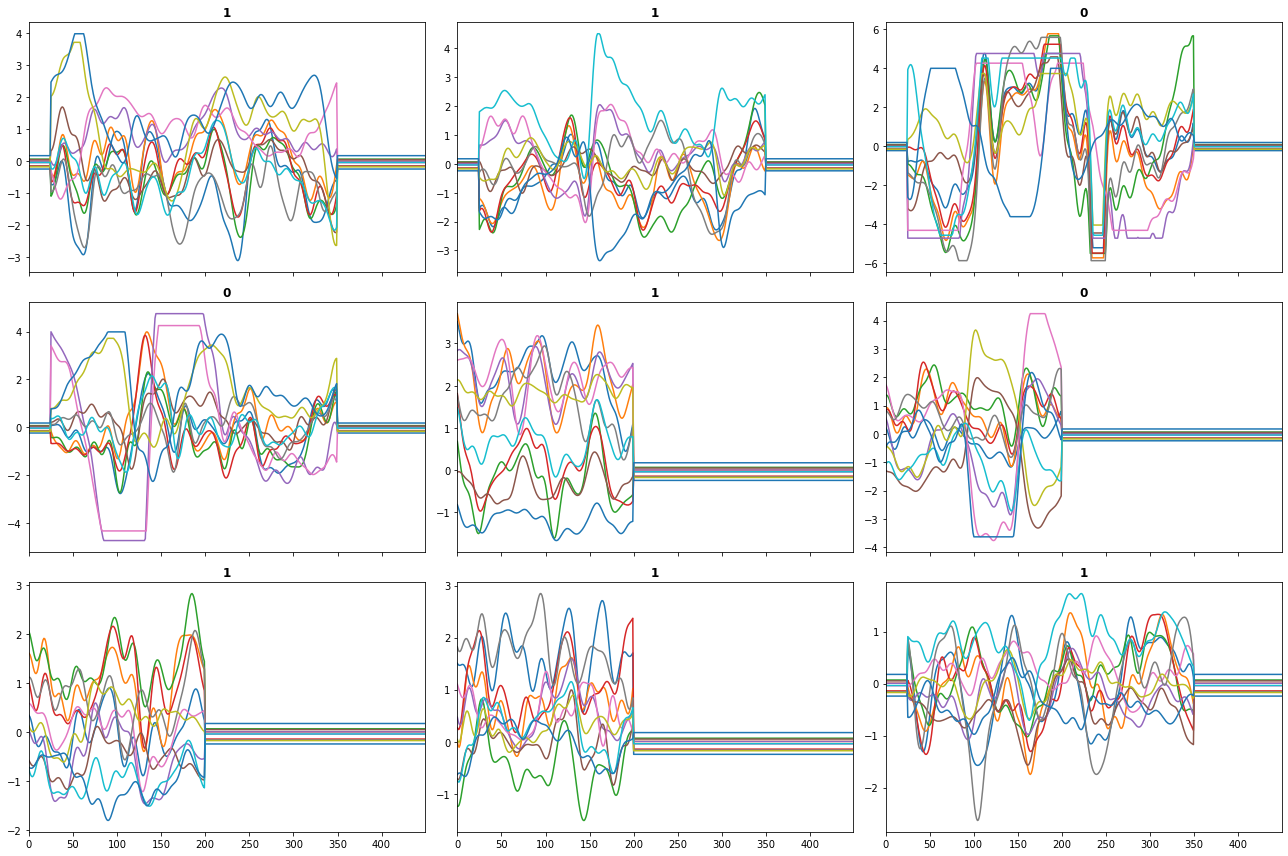

In [19]:
bs = 64
tfms  = [None, [TSClassification()]]
dsets = TSDatasets(xw, target, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=TSStandardize(by_var=True))
dls.show_batch()

SuggestedLRs(valley=2.0892961401841603e-05)

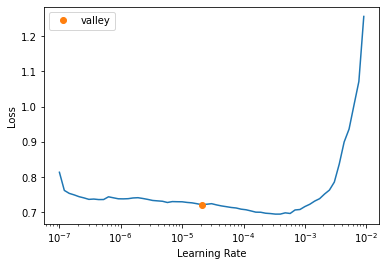

In [20]:
model = TST(dls.vars, dls.c, dls.len)
learn = Learner(dls, model,loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=[ShowGraphCallback2(),SaveModel(monitor='accuracy')])
learn.lr_find()

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.539151,0.535829,0.864363,0.792410,00:49
1,0.500563,0.494117,0.892683,0.811309,00:50
2,0.482772,0.475304,0.906181,0.822557,00:50
3,0.459685,0.467117,0.907721,0.830745,00:50
4,0.453040,0.458516,0.914492,0.833958,00:50
5,0.443776,0.470556,0.913423,0.824394,00:50
6,0.423937,0.446506,0.919954,0.841533,00:49
7,0.424163,0.447334,0.922630,0.839850,00:50
8,0.414324,0.457540,0.920258,0.832275,00:50
9,0.421991,0.454527,0.920433,0.836177,00:50


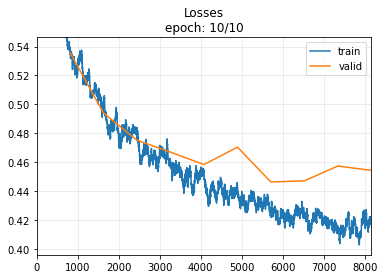

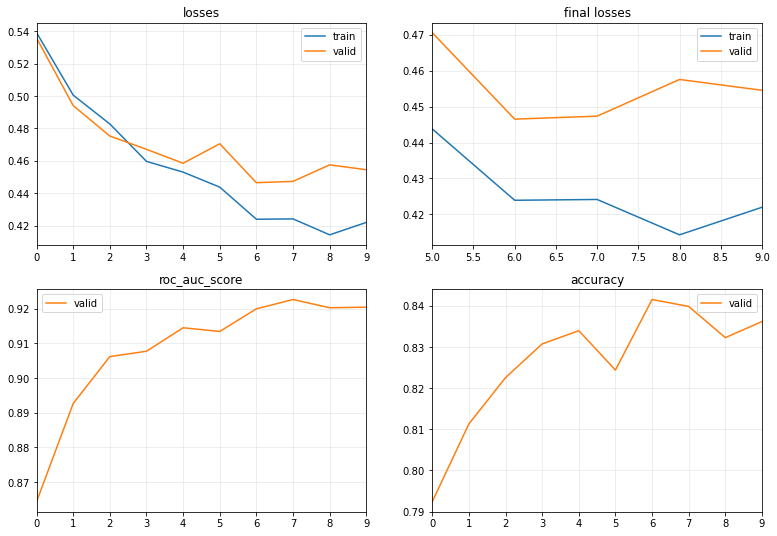


Elapsed time: 503.73212337493896


In [22]:
model = TST(dls.vars, dls.c, dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(),metrics=[RocAucBinary(), accuracy], cbs=[ShowGraphCallback2(),SaveModel(monitor='accuracy')])
start = time.time()
learn.fit_one_cycle(10, lr_max=3e-5)
print('\nElapsed time:', time.time() - start)
#learn.plot_metrics()
#learn.show_probas()
#learn.plot_confusion_matrix()

In [23]:
PATH = Path('./models/Trasnformer2classes.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

In [24]:
#del learn

In [25]:
PATH = Path('./models/Trasnformer2classes.pkl')
learn_gpu = load_learner(PATH, cpu=False)

In [26]:
probas, _, preds = learn_gpu.get_X_preds(xw[splits[1]])
preds

array(['0', '0', '1', ..., '0', '0', '1'], dtype='<U1')

In [27]:
x_test = xw[splits[1]]
y_test = target[splits[1]]

In [28]:
import sklearn
sklearn.metrics.accuracy_score(y_test, preds)

0.841533399648022

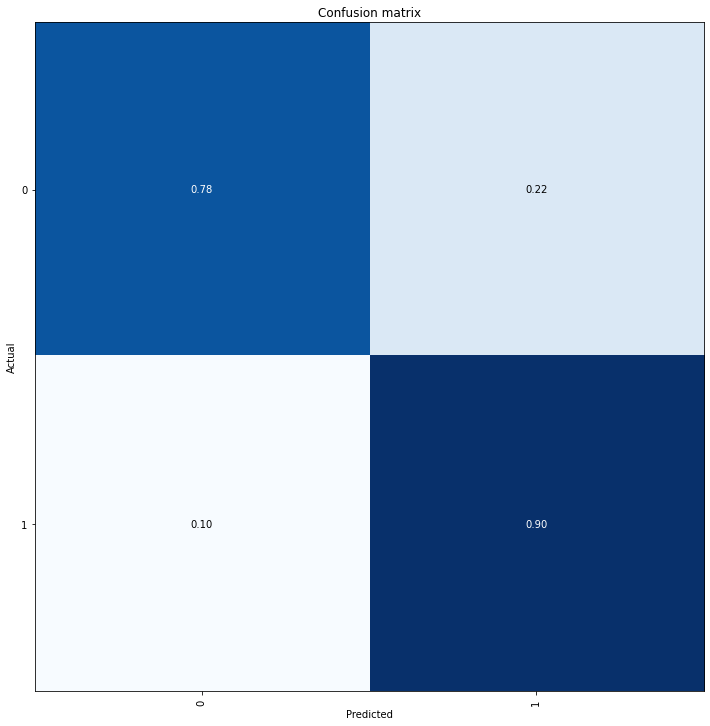

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True,figsize=(10,10))

X.shape: (13069, 11, 450)
y.shape: (13069,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 0.480603


  0 feature: var_0                accuracy: 0.484964


  1 feature: var_1                accuracy: 0.474099


  2 feature: var_2                accuracy: 0.482057


  3 feature: var_3                accuracy: 0.487719


  4 feature: var_4                accuracy: 0.490933


  5 feature: var_5                accuracy: 0.497972


  6 feature: var_6                accuracy: 0.498584


  7 feature: var_7                accuracy: 0.482133


  8 feature: var_8                accuracy: 0.481062


  9 feature: var_9                accuracy: 0.466065


 10 feature: var_10               accuracy: 0.606550



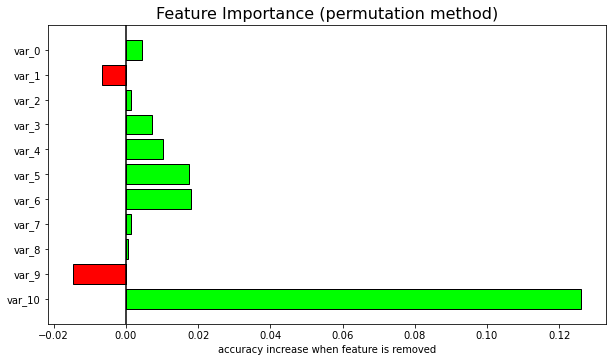

,Feature,accuracy,accuracy_change
0,var_10,0.606550,0.125947
1,var_6,0.498584,0.017981
2,var_5,0.497972,0.017369
3,var_4,0.490933,0.010330
4,var_3,0.487719,0.007116
5,var_0,0.484964,0.004361
6,var_7,0.482133,0.001530
7,var_2,0.482057,0.001454
8,var_8,0.481062,0.000459
9,BASELINE,0.480603,0.000000


In [30]:
learn.feature_importance(key_metric_idx=1)

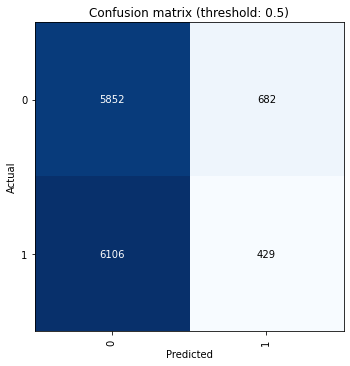

In [37]:
learn.plot_confusion_matrix()